# **TIM: haruki murakami**

#  Gambaran Umum Metodologi

Pendekatan yang kami ajukan untuk kompetisi *crowd counting* ini berpusat pada penggunaan **CSRNet**, sebuah arsitektur *Convolutional Neural Network (CNN)* yang telah terbukti andal untuk tugas estimasi kepadatan kerumunan. Alur kerja kami dirancang secara sistematis, mulai dari persiapan data hingga pembuatan file submisi.

Secara garis besar, alur kerja kami adalah sebagai berikut:

1.  **Persiapan Data**: Langkah awal adalah mengorganisir seluruh data gambar dan label jumlahnya ke dalam sebuah `pandas DataFrame`. Kami juga mendefinisikan skema *cross-validation* dengan 5-fold, namun berdasarkan eksperimen dan untuk efisiensi komputasi, kami membuat keputusan strategis untuk **hanya menggunakan model terbaik dari Fold 1** untuk proses inferensi dan submisi akhir.

2.  **Dataset & Augmentasi**: Kami membuat *custom Dataset class* di PyTorch untuk memuat gambar dan menghasilkan *ground truth density map*. *Density map* ini menjadi target pembelajaran bagi model, bukan angka absolutnya. Untuk meningkatkan robustisitas model, kami menerapkan serangkaian teknik augmentasi data, termasuk augmentasi geometri (seperti *Horizontal Flip*) dan warna. Secara khusus, kami menggunakan **CoarseDropout** untuk menyimulasikan oklusi, melatih model agar tetap dapat melakukan prediksi akurat meskipun sebagian area gambar tertutup.

3.  **Arsitektur Model**: Kami mengimplementasikan **CSRNet**. Model ini terdiri dari dua bagian utama: *frontend* berbasis VGG-16 (yang sudah di-pretrained di ImageNet) untuk ekstraksi fitur-fitur penting, dan *backend* yang menggunakan *dilated convolutions* untuk menghasilkan *density map* beresolusi tinggi tanpa kehilangan informasi kontekstual spasial.

4.  **Proses Training**: Model dilatih untuk meminimalkan *loss function* **Mean Squared Error (MSE)** antara *density map* yang diprediksi dengan *ground truth*. Sebagai metrik evaluasi utama yang relevan dengan kriteria kompetisi, kami memantau **Mean Absolute Error (MAE)** pada jumlah total orang pada set validasi. Optimizer yang digunakan adalah Adam. Model dengan performa MAE terbaik pada data validasi dari Fold 1 disimpan untuk digunakan pada tahap selanjutnya.

5.  **Inferensi dan Submisi**: Model terbaik yang telah disimpan dari Fold 1 kemudian digunakan untuk melakukan prediksi pada *test set*. Untuk setiap gambar tes, model menghasilkan *density map*, dan kami menjumlahkan semua nilai piksel pada map tersebut untuk mendapatkan estimasi jumlah orang. Hasil prediksi ini kemudian diformat ke dalam sebuah file `submission.csv` sesuai dengan ketentuan kompetisi.


# INSTALASI, IMPORT, DAN KONEKSI GOOGLE DRIVE

In [ ]:
!pip install -q albumentations kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 31.9 MB/s eta 0:00:00


In [ ]:
import os
import glob
import json
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Scikit-learn
from sklearn.model_selection import StratifiedKFold

# Albumentations (Augmentasi)
import albumentations as A
from albumentations.pytorch import ToTensorV2

# SciPy (Untuk membuat density map)
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter

from kornia.losses import ssim_loss

# Koneksi ke Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Libraries Imported and Drive Mounted.")

Mounted at /content/drive
Libraries Imported and Drive Mounted.


# KONFIGURASI DAN PATH

---



In [ ]:
class CFG:
    # --- Path Utama ---
    BASE_PATH = '/content/drive/MyDrive/hology/'

    # --- Path Dataset ---
    DATASET_PATH = os.path.join(BASE_PATH, 'dataset')
    TRAIN_IMG_PATH = os.path.join(DATASET_PATH, 'train/images')
    TRAIN_LBL_PATH = os.path.join(DATASET_PATH, 'train/labels')
    TEST_IMG_PATH = os.path.join(DATASET_PATH, 'test/images')
    SAMPLE_SUB_PATH = os.path.join(DATASET_PATH, 'sample_submission.csv')

    # --- Path Checkpoint & Output ---
    PREPROCESSED_PATH = os.path.join(BASE_PATH, 'preprocessed_data_adaptive')
    MODEL_SAVE_PATH = os.path.join(BASE_PATH, 'models_csrnet')

    # --- Path Submission ---
    SUBMISSION_PATH = os.path.join(BASE_PATH, 'submission.csv')

    # --- Konfigurasi Model & Training ---
    SEED = 42
    N_FOLDS = 5

    MAX_EPOCHS = 100
    SCHEDULER_PATIENCE = 5
    EARLY_STOPPING_PATIENCE = 15

    BATCH_SIZE = 8
    LEARNING_RATE = 1e-5
    STRIDE = 8

    # --- Konfigurasi Density Map ---
    ADAPTIVE_K = 3
    ADAPTIVE_BETA = 0.3
    DEFAULT_SIGMA = 15.0

    # --- Augmentasi ---
    IMG_SIZE = 512

# Fungsi untuk reproducibility
def set_seed(seed=CFG.SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG.SEED)

os.makedirs(CFG.PREPROCESSED_PATH, exist_ok=True)
os.makedirs(CFG.MODEL_SAVE_PATH, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
print(f"All paths and configurations set. Checkpoint folders created.")
print(f"Training set for MAX_EPOCHS={CFG.MAX_EPOCHS} with EarlyStopping Patience={CFG.EARLY_STOPPING_PATIENCE}")

Using device: cpu
All paths and configurations set. Checkpoint folders created.
Training set for MAX_EPOCHS=100 with EarlyStopping Patience=15


# SEL EXPLORATORY DATA ANALYSIS

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random

# ==============================================================================
# 0. PENGATURAN DAN KONFIGURASI
# ==============================================================================
# --- Narasi: Pendahuluan ---
print("==============================================================================")
print("BAGIAN 1: VISUALISASI DAN PEMAHAMAN DATA")
print("==============================================================================")
print("Tujuan: Menganalisis dataset penghitungan kerumunan secara menyeluruh untuk memahami karakteristiknya, menemukan pola tersembunyi, dan membenarkan pendekatan pemodelan akhir kami.")

sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (16, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# ==============================================================================
# 1. PEMUATAN DATA AWAL & TINJAUAN UMUM
# ==============================================================================
# --- Narasi ---
print("\n--- 1.1. Pemuatan Data Awal & Tinjauan Umum ---")
print("Langkah pertama kami adalah memuat dan memeriksa dataset. Ini akan memberikan pemahaman dasar tentang ukuran dan rentang jumlah kerumunan yang kami hadapi.")

# --- Aksi: Memuat Data ---
data = []
label_files = [f for f in os.listdir(CFG.TRAIN_LBL_PATH) if f.endswith('.json')]

for label_file in tqdm(label_files, desc="Memuat file label"):
    file_path = os.path.join(CFG.TRAIN_LBL_PATH, label_file)
    with open(file_path, 'r') as f:
        label_data = json.load(f)

    img_path = os.path.join(CFG.TRAIN_IMG_PATH, label_data['img_id'])
    if os.path.exists(img_path):
        data.append({
            'image_id': label_data['img_id'],
            'human_num': label_data['human_num'],
            'image_path': img_path
        })

df = pd.DataFrame(data)

print("\nKepala DataFrame:")
print(df.head())
print(f"\nTotal sampel latih yang dimuat: {len(df)}")

print("\nStatistik ringkasan untuk jumlah kerumunan (`human_num`):")
print(df['human_num'].describe())

print("\nWawasan: Statistik ringkasan segera menyoroti tantangan inti: rentang jumlah kerumunan yang sangat besar, dari 1 hingga lebih dari 3000 orang, dengan standar deviasi yang sangat tinggi.")


BAGIAN 1: VISUALISASI DAN PEMAHAMAN DATA
Tujuan: Menganalisis dataset penghitungan kerumunan secara menyeluruh untuk memahami karakteristiknya, menemukan pola tersembunyi, dan membenarkan pendekatan pemodelan akhir kami.

--- 1.1. Pemuatan Data Awal & Tinjauan Umum ---
Langkah pertama kami adalah memuat dan memeriksa dataset. Ini akan memberikan pemahaman dasar tentang ukuran dan rentang jumlah kerumunan yang kami hadapi.


Memuat file label:   0%|          | 0/1900 [00:00<?, ?it/s]


Kepala DataFrame:
   image_id  human_num                                         image_path
0   331.jpg        156  /content/drive/MyDrive/hology/dataset/train/im...
1  1802.jpg         60  /content/drive/MyDrive/hology/dataset/train/im...
2   322.jpg          3  /content/drive/MyDrive/hology/dataset/train/im...
3  1769.jpg          7  /content/drive/MyDrive/hology/dataset/train/im...
4  1805.jpg        136  /content/drive/MyDrive/hology/dataset/train/im...

Total sampel latih yang dimuat: 1900

Statistik ringkasan untuk jumlah kerumunan (`human_num`):
count    1900.000000
mean      138.899474
std       285.247091
min         1.000000
25%        10.000000
50%        28.000000
75%       146.000000
max      3139.000000
Name: human_num, dtype: float64

Wawasan: Statistik ringkasan segera menyoroti tantangan inti: rentang jumlah kerumunan yang sangat besar, dari 1 hingga lebih dari 3000 orang, dengan standar deviasi yang sangat tinggi.



--- 1.2. Memvisualisasikan Keragaman Pemandangan Kerumunan ---
Narasi: Inspeksi visual sangat penting untuk memahami kompleksitas gambar. Kami menemukan perbedaan besar dalam kepadatan kerumunan, pencahayaan, perspektif, dan skala.


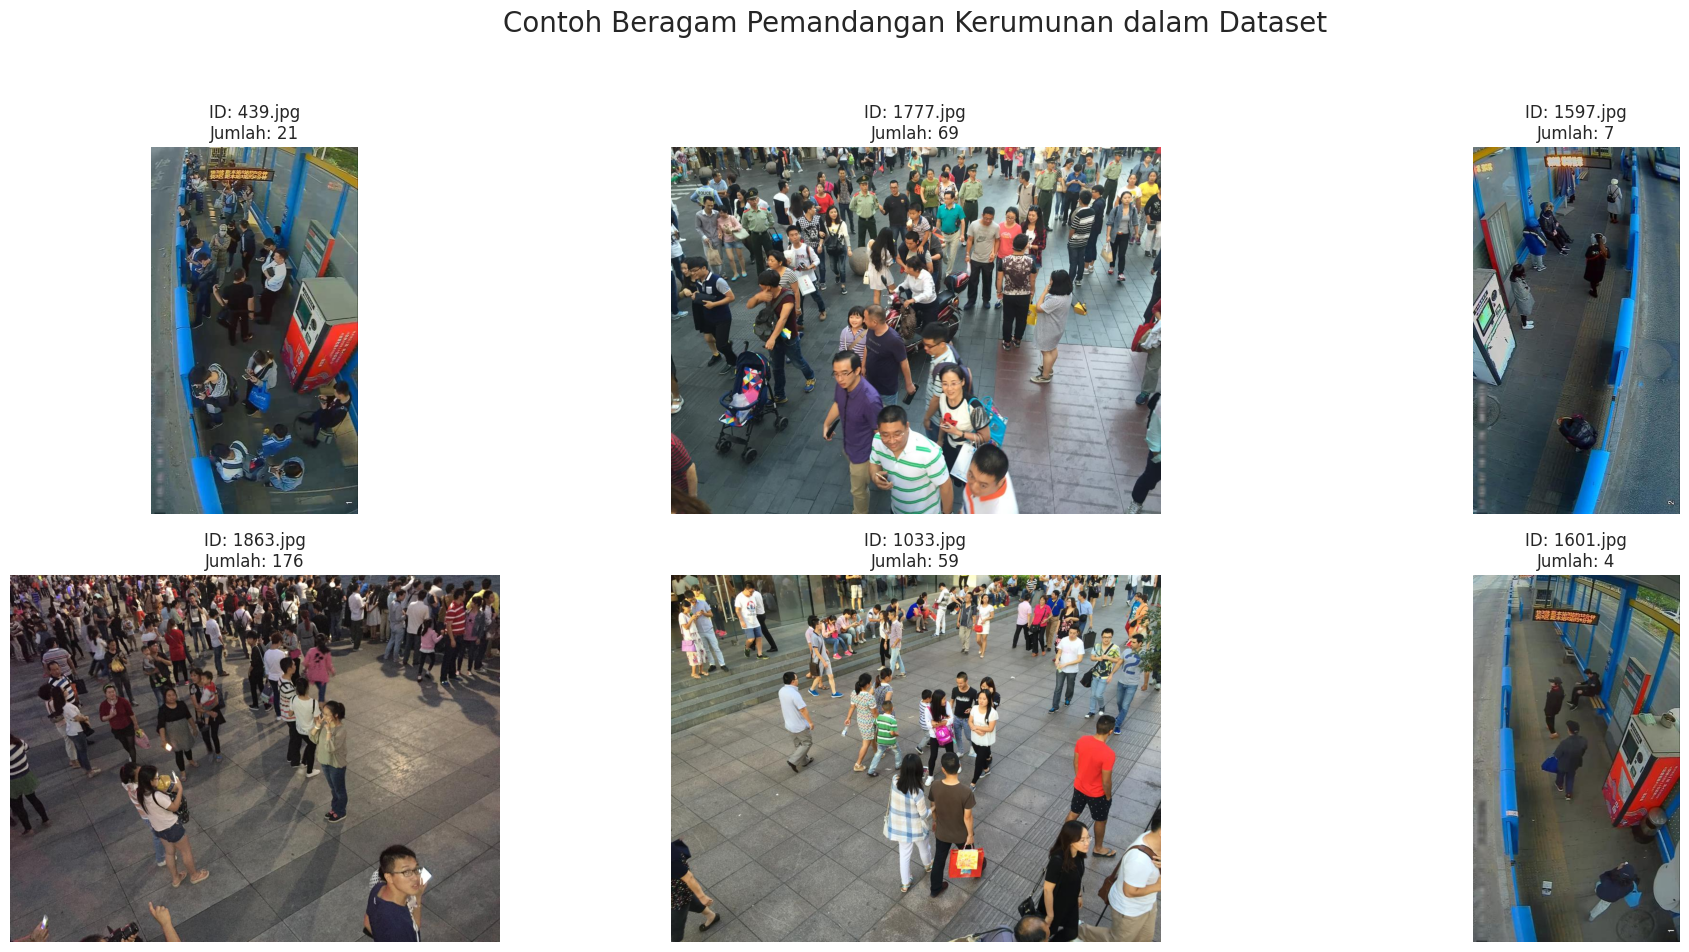

In [ ]:
print("\n--- 1.2. Memvisualisasikan Keragaman Pemandangan Kerumunan ---")
print("Narasi: Inspeksi visual sangat penting untuk memahami kompleksitas gambar. Kami menemukan perbedaan besar dalam kepadatan kerumunan, pencahayaan, perspektif, dan skala.")

def show_image_grid(df, num_images=6):
    sample_indices = random.sample(range(len(df)), num_images)
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(sample_indices):
        row = df.iloc[idx]
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"ID: {row['image_id']}\nJumlah: {row['human_num']}", fontsize=12)
        plt.axis('off')
    plt.suptitle("Contoh Beragam Pemandangan Kerumunan dalam Dataset", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

show_image_grid(df)


--- 1.3. Insights: Menganalisis Dimensi Gambar dan Kepadatan Kerumunan ---
Analisis kami terhadap dimensi gambar mengungkapkan wawasan penting: dataset ini bukanlah masalah tunggal yang seragam. Rasio aspek membentuk distribusi bimodal, menunjukkan adanya dua rezim data yang berbeda.


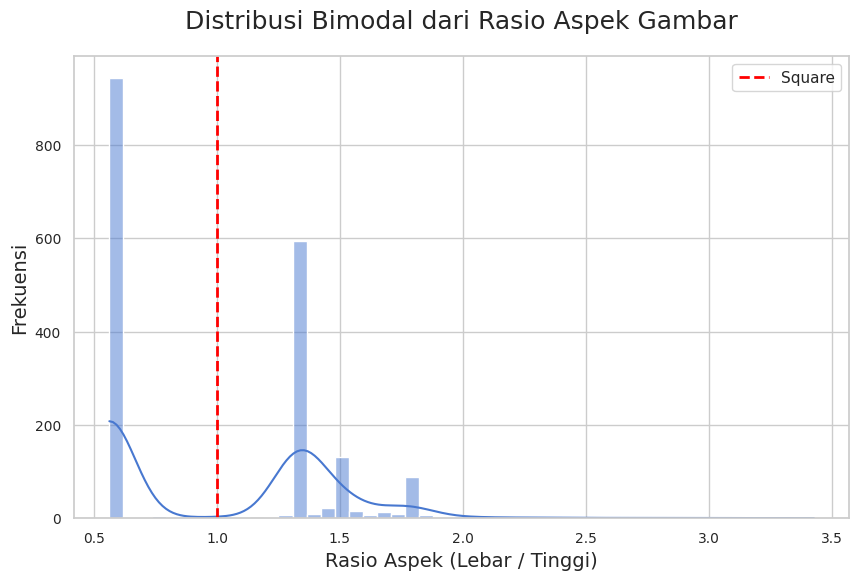

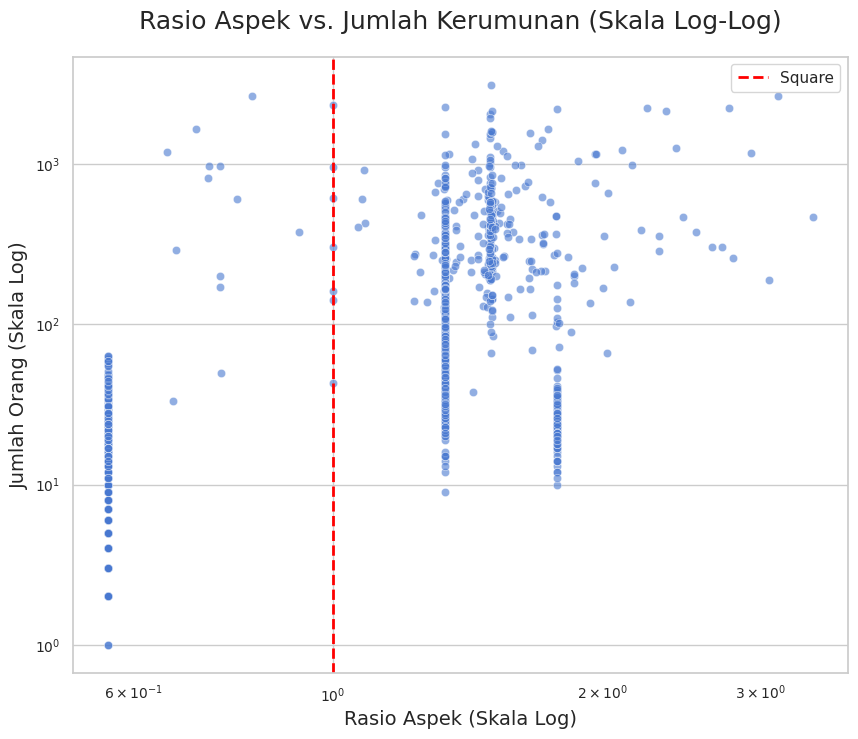

In [ ]:
print("\n--- 1.3. Insights: Menganalisis Dimensi Gambar dan Kepadatan Kerumunan ---")
print("Analisis kami terhadap dimensi gambar mengungkapkan wawasan penting: dataset ini bukanlah masalah tunggal yang seragam. Rasio aspek membentuk distribusi bimodal, menunjukkan adanya dua rezim data yang berbeda.")

plt.figure(figsize=(10, 6))
sns.histplot(df['aspect_ratio'], kde=True, bins=50)
plt.title('Distribusi Bimodal dari Rasio Aspek Gambar', fontsize=18, pad=20)
plt.xlabel('Rasio Aspek (Lebar / Tinggi)', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.axvline(1, color='red', linestyle='--', linewidth=2, label="Square")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
g = sns.scatterplot(data=df, x='aspect_ratio', y='human_num', alpha=0.6)
g.set_yscale('log')
g.set_xscale('log')
plt.axvline(1, color='red', linestyle='--', linewidth=2, label="Square")
plt.title('Rasio Aspek vs. Jumlah Kerumunan (Skala Log-Log)', fontsize=18, pad=20)
plt.xlabel('Rasio Aspek (Skala Log)', fontsize=14)
plt.ylabel('Jumlah Orang (Skala Log)', fontsize=14)
plt.legend()
plt.show()

Distribusi bimodal dari rasio aspek adalah perantara yang kuat untuk dua rezim data yang berbeda. <br>Plot sebar mengonfirmasi hipotesis kami: gambar bergaya lanskap bertanggung jawab atas hampir semua skenario kepadatan sangat tinggi. Penemuan ini membuktikan bahwa model generalis yang sukses harus cukup kuat untuk menangani case yang sepi maupun yang padat.
<br><br>
Dari hasil insight EDA ini, kami fokus pada approach berbasis density map untuk model CSRNet kami.


# PERSIAPAN DATA (MEMBUAT DATA FRAME)




Tahap pertama adalah persiapan data. Di bagian ini, tujuan utamanya adalah untuk mengumpulkan dan menstrukturkan semua informasi yang relevan ke dalam format yang mudah diakses dan dimanipulasi. Kami menggunakan `pandas DataFrame` sebagai wadah utama.

Langkah-langkah yang dilakukan adalah:
1.  **Mengumpulkan Path File**: Kami memindai direktori data untuk mendapatkan path lengkap dari setiap gambar training dan testing.
2.  **Menggabungkan dengan Label**: Path gambar training dicocokkan dengan labelnya (jumlah orang), yang disediakan dalam file terpisah. Informasi ini kemudian digabungkan menjadi satu DataFrame tunggal.
3.  **Mendefinisikan Skema Validasi**: Untuk mengukur performa model secara objektif dan menghindari *overfitting*, kami menggunakan strategi *K-Fold Cross-Validation*. Data training dibagi menjadi 5 *folds*. Ini memungkinkan kami untuk melatih model pada 4 *folds* dan memvalidasinya pada 1 *fold* yang tersisa, dan mengulanginya sebanyak 5 kali.
4.  **Keputusan Strategis**: Meskipun kami mendefinisikan 5 *folds*, untuk submisi final ini, kami memutuskan untuk **fokus melatih model hanya pada data dari Fold 1**. Model terbaik dari proses training dan validasi di fold inilah yang akan dipilih untuk tahap inferensi. Keputusan ini diambil untuk menyederhanakan *pipeline* dan fokus pada kualitas satu model yang solid.

Hasil dari tahap ini adalah sebuah DataFrame yang rapi, berisi kolom untuk path gambar, jumlah orang, dan nomor *fold* untuk setiap data.

In [ ]:
def get_train_dataframe(img_path, lbl_path):
    """
    Membuat DataFrame pandas awal dari file gambar dan label.
    """
    image_files = sorted(glob.glob(os.path.join(img_path, '*.jpg')))
    label_files = sorted(glob.glob(os.path.join(lbl_path, '*.json')))

    data = []

    for img_f, lbl_f in zip(image_files, label_files):
        img_id = os.path.basename(img_f).split('.')[0]
        lbl_id = os.path.basename(lbl_f).split('.')[0]

        # Pastikan gambar dan label cocok
        assert img_id == lbl_id, f"Mismatch: {img_id} vs {lbl_id}"

        # Muat file JSON untuk mendapatkan human_num
        with open(lbl_f, 'r') as f:
            label_data = json.load(f)
            human_num = label_data['human_num']

        data.append({
            'image_id': img_id,
            'image_path': img_f,
            'label_path': lbl_f,
            'density_map_path': os.path.join(CFG.PREPROCESSED_PATH, f"{img_id}.npy"),
            'human_num': human_num
        })

    df = pd.DataFrame(data)
    print(f"Created DataFrame with {len(df)} training samples.")
    return df

try:
    train_df = get_train_dataframe(CFG.TRAIN_IMG_PATH, CFG.TRAIN_LBL_PATH)
    display(train_df.head())
except Exception as e:
    print(f"Error: Tidak dapat menemukan file training. Pastikan path Anda benar.")
    print(f"BASE_PATH: {CFG.BASE_PATH}")
    print(f"Error details: {e}")

Created DataFrame with 1900 training samples.


image_id                                         image_path  \
0        1  /content/drive/MyDrive/hology/dataset/train/im...   
1       10  /content/drive/MyDrive/hology/dataset/train/im...   
2      100  /content/drive/MyDrive/hology/dataset/train/im...   
3     1000  /content/drive/MyDrive/hology/dataset/train/im...   
4     1001  /content/drive/MyDrive/hology/dataset/train/im...   

                                          label_path  \
0  /content/drive/MyDrive/hology/dataset/train/la...   
1  /content/drive/MyDrive/hology/dataset/train/la...   
2  /content/drive/MyDrive/hology/dataset/train/la...   
3  /content/drive/MyDrive/hology/dataset/train/la...   
4  /content/drive/MyDrive/hology/dataset/train/la...   

                                    density_map_path  human_num  
0  /content/drive/MyDrive/hology/preprocessed_dat...        539  
1  /content/drive/MyDrive/hology/preprocessed_dat...         59  
2  /content/drive/MyDrive/hology/preprocessed_dat...         16  
3  /content/drive/MyDrive/hology/preprocessed_dat...         30  
4  /content/drive/MyDrive/hology/preprocessed_dat...        363

# PEMBUATAN DENSITY MAP

Apa itu? Alih-alih menyuruh model untuk menghitung, kita melatihnya untuk membuat heatmap dari kerumunan, di mana area terang menunjukkan kepadatan orang yang tinggi.

Bagaimana caranya?

Ground Truth: Setiap kepala orang [x],[y] di data training diubah menjadi sebuah gaussian distribution pada peta. Area padat akan memiliki noda yang tumpang tindih dan menjadi lebih terang. Kita juga menerapkan adaptive parameter untuk lebih akurat merepresentasikan crowd padat.

Training: Model belajar untuk mengubah gambar asli menjadi heatmap yang semirip mungkin dengan ground truth tersebut.

Menghitung: Jumlah total orang didapat dengan menjumlahkan semua nilai piksel (kecerahan) pada peta panas yang diprediksi model.

Mengapa efektif? Pendekatan ini secara alami mengatasi masalah oklusi (orang saling tumpuk) dan variasi skala karena model tidak perlu melihat setiap individu secara terpisah.

In [ ]:
print(f"Starting Density Map Generation (Checkpoint-able)...")
print(f"Saving maps to: {CFG.PREPROCESSED_PATH}")

for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Processing Density Maps"):

    if os.path.exists(row['density_map_path']):
        continue

    # --- 1. Muat Data ---
    img = Image.open(row['image_path'])
    img_shape = np.array(img).shape

    with open(row['label_path'], 'r') as f:
        label_data = json.load(f)

    points_data = label_data.get('points', [])

    if isinstance(points_data, list) and len(points_data) > 0 and isinstance(points_data[0], dict):
        # Format terdeteksi: list of dicts, e.g., [{"x": 120, "y": 45}, ...]
        try:
            points = np.array([[pt['x'], pt['y']] for pt in points_data], dtype=np.float32)
        except KeyError:
            points = np.array([list(pt.values())[:2] for pt in points_data], dtype=np.float32)
    else:
        points = np.array(points_data, dtype=np.float32)


    # --- 2. Siapkan Density Map ---
    # Output map akan 1/8 dari ukuran asli, sesuai stride model
    map_shape = (img_shape[0] // CFG.STRIDE, img_shape[1] // CFG.STRIDE)
    density_map = np.zeros(map_shape, dtype=np.float32)

    # --- 3. Hitung Sigma Adaptif ---
    # Handle edge cases (0 atau 1 orang)
    if points.shape[0] == 0:
        # Tidak ada orang, simpan map kosong
        np.save(row['density_map_path'], density_map)
        continue

    if points.shape[0] == 1:
        # Hanya 1 orang, gunakan sigma tetap
        sigmas = np.array([CFG.DEFAULT_SIGMA])
    else:
        # Lebih dari 1 orang, gunakan k-NN adaptif
        kdtree = cKDTree(points)
        query_k = min(CFG.ADAPTIVE_K + 1, points.shape[0])
        distances, _ = kdtree.query(points, k=query_k)
        mean_distances = np.mean(distances[:, 1:], axis=1)

        sigmas = mean_distances * CFG.ADAPTIVE_BETA
        sigmas[sigmas == 0] = CFG.DEFAULT_SIGMA

    # --- 4. Buat Density Map ---
    for i in range(points.shape[0]):
        pt = points[i]
        sigma = sigmas[i]

        # Skalakan koordinat dan sigma ke ukuran map
        scaled_pt = (pt[1] // CFG.STRIDE, pt[0] // CFG.STRIDE) # (y, x)
        scaled_sigma = sigma / CFG.STRIDE

        y, x = int(scaled_pt[0]), int(scaled_pt[1])
        kernel_size = int(np.ceil(scaled_sigma * 3)) * 2 + 1

        # Pastikan y dan x berada dalam batas map
        if y < 0 or y >= map_shape[0] or x < 0 or x >= map_shape[1]:
            continue

        # Buat kernel Gaussian tunggal
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[kernel_size // 2, kernel_size // 2] = 1.0 # Titik tengah
        # Terapkan filter Gaussian
        gaussian_blob = gaussian_filter(kernel, sigma=scaled_sigma)

        # Tentukan di mana menempatkan blob ini di density_map
        y_start = max(0, y - kernel_size // 2)
        y_end = min(map_shape[0], y + kernel_size // 2 + 1)
        x_start = max(0, x - kernel_size // 2)
        x_end = min(map_shape[1], x + kernel_size // 2 + 1)

        # Tentukan bagian dari blob yang akan digunakan
        blob_y_start = max(0, kernel_size // 2 - y)
        blob_y_end = blob_y_start + (y_end - y_start)
        blob_x_start = max(0, kernel_size // 2 - x)
        blob_x_end = blob_x_start + (x_end - x_start)

        # Tambahkan blob ke density map
        try:
            density_map[y_start:y_end, x_start:x_end] += gaussian_blob[blob_y_start:blob_y_end, blob_x_start:blob_x_end]
        except ValueError as e:
            # Error ini bisa terjadi jika ada perhitungan yang salah
            print(f"Error adding blob for point {pt} in {row['image_id']}.")
            print(f"Map shape: {density_map.shape}, Blob shape: {gaussian_blob.shape}")
            print(f"Coords: y[{y_start}:{y_end}], x[{x_start}:{x_end}]")
            print(f"Blob coords: y[{blob_y_start}:{blob_y_end}], x[{blob_x_start}:{blob_x_end}]")
            print(f"Debug Info: scaled_sigma={scaled_sigma}, kernel_size={kernel_size}")

    # --- 5. Simpan Map (Checkpoint) ---
    np.save(row['density_map_path'], density_map)

print("Density Map Generation Complete. All files saved to Drive.")

Starting Density Map Generation (Checkpoint-able)...
Saving maps to: /content/drive/MyDrive/hology/preprocessed_data_adaptive


Processing Density Maps:   0%|          | 0/1900 [00:00<?, ?it/s]

Density Map Generation Complete. All files saved to Drive.



--- 1.5. Visualisasi Ground Truth & Peta Kepadatan (Density Map) ---
Untuk melatih model CSRNet, kita tidak hanya menggunakan jumlah, tetapi juga peta kepadatan 2D yang merepresentasikan lokasi setiap orang. Memvisualisasikan peta ini sangat penting untuk memastikan kualitas data pelatihan kami.

Memvisualisasikan contoh gambar dengan kepadatan rendah:


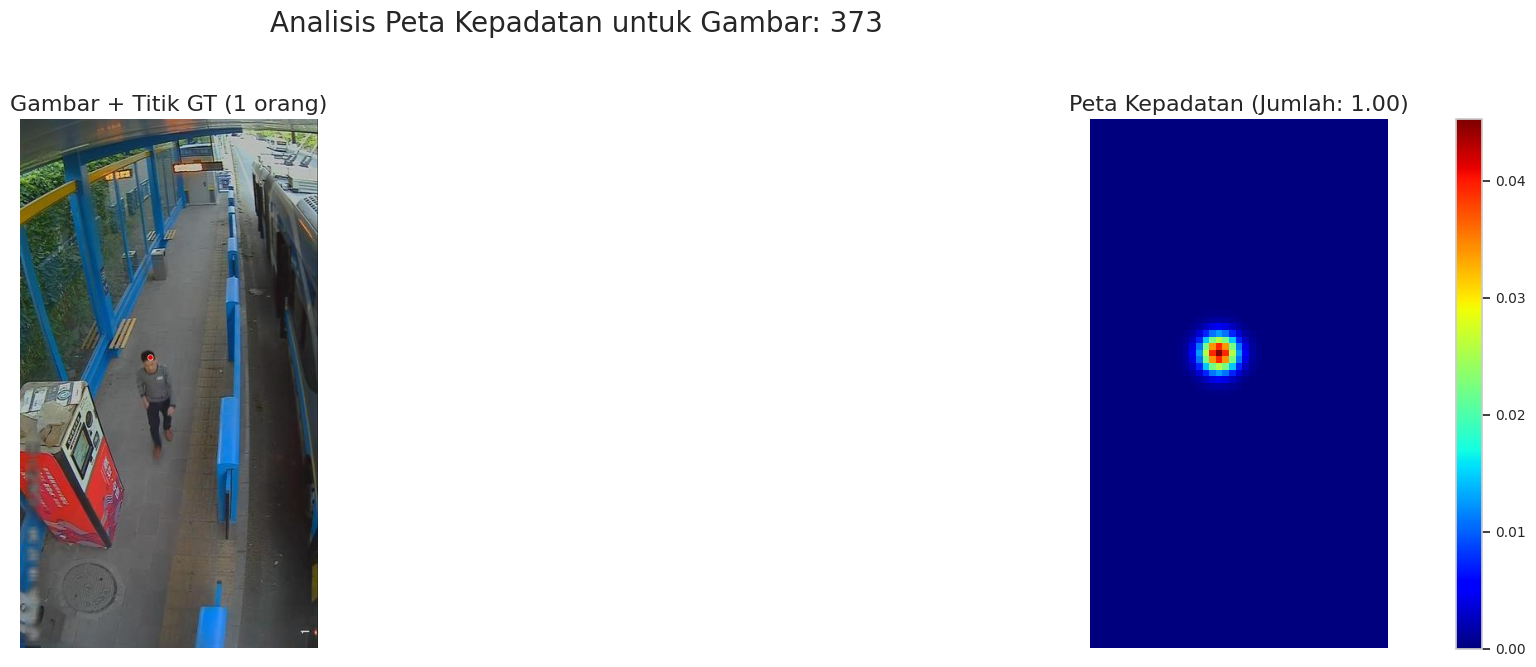


Memvisualisasikan contoh gambar dengan kepadatan tinggi:


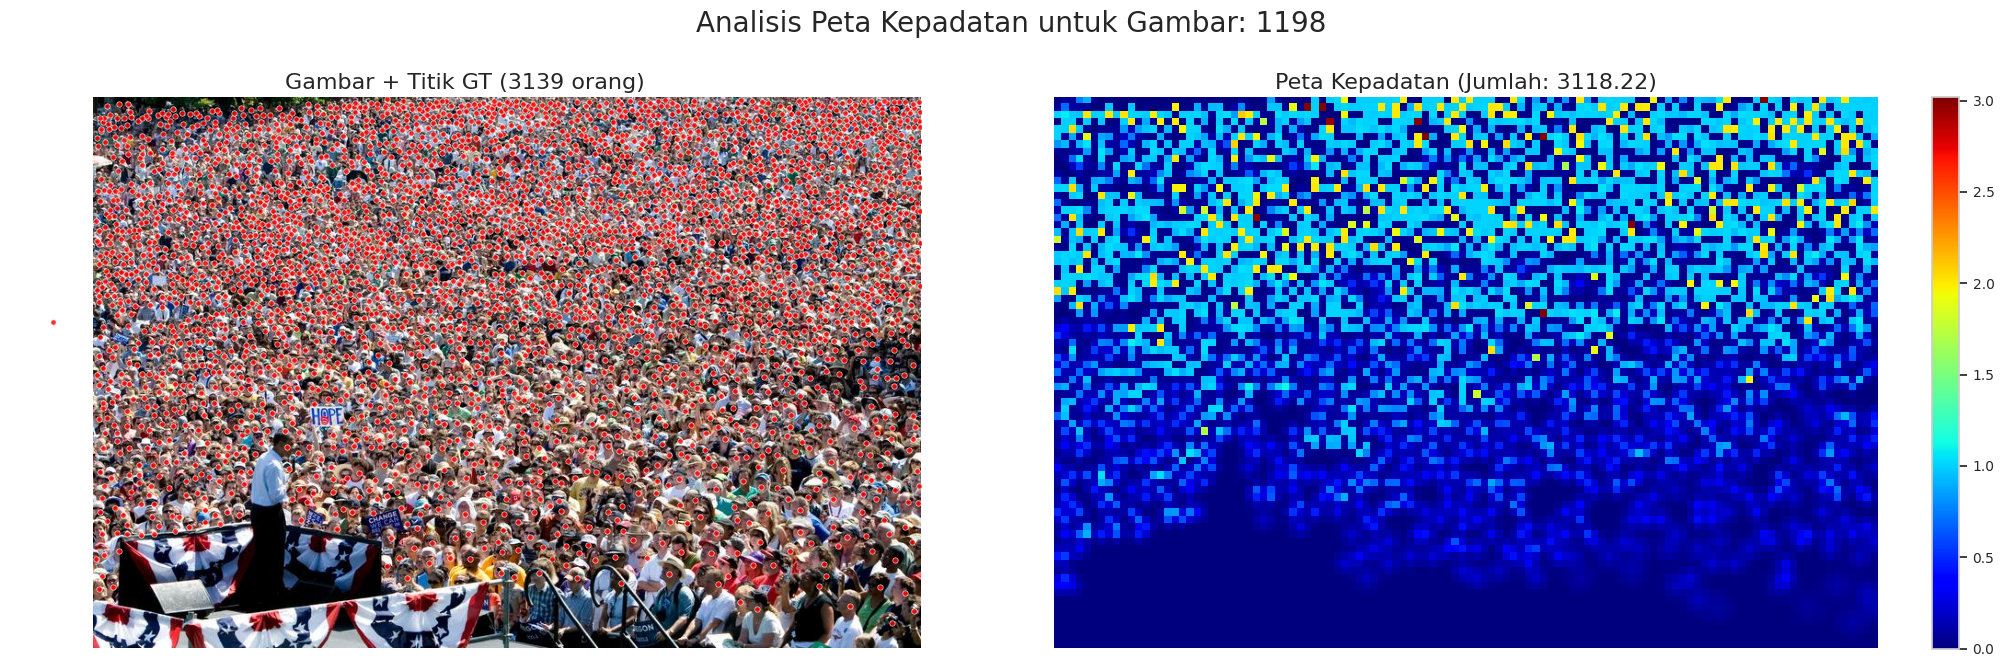

In [ ]:
print("\n--- 1.5. Visualisasi Ground Truth & Peta Kepadatan (Density Map) ---")
print("Untuk melatih model CSRNet, kita tidak hanya menggunakan jumlah, tetapi juga peta kepadatan 2D yang merepresentasikan lokasi setiap orang. Memvisualisasikan peta ini sangat penting untuk memastikan kualitas data pelatihan kami.")

def visualize_density_map(row):
    # Muat data yang diperlukan
    img = Image.open(row['image_path'])

    with open(row['label_path'], 'r') as f:
        label_data = json.load(f)
    points_data = label_data.get('points', [])

    # Konversi titik-titik ke format numpy
    points = np.array([[p['x'], p['y']] for p in points_data], dtype=np.float32)

    # Muat density map
    density_map_path = os.path.join(CFG.PREPROCESSED_PATH, f"{os.path.splitext(row['image_id'])[0]}.npy")
    try:
        density_map = np.load(density_map_path)
    except FileNotFoundError:
        print(f"Peringatan: File density map tidak ditemukan di {density_map_path}")
        return

    # Hitung jumlah dari density map untuk perbandingan
    map_sum = np.sum(density_map)
    gt_count = row['human_num']

    # Membuat plot
    fig, axes = plt.subplots(1, 2, figsize=(22, 7))

    # Panel 1: Gambar Asli + Titik Ground Truth
    ax1 = axes[0]
    ax1.imshow(img)
    if len(points) > 0:
        ax1.scatter(points[:, 0], points[:, 1], c='red', s=15, edgecolors='white', linewidths=0.5, alpha=0.8)
    ax1.set_title(f"Gambar + Titik GT ({gt_count} orang)")
    ax1.axis('off')

    # Panel 2: Peta Kepadatan yang Dihasilkan
    ax2 = axes[1]
    im = ax2.imshow(density_map, cmap='jet')
    ax2.set_title(f"Peta Kepadatan (Jumlah: {map_sum:.2f})")
    ax2.axis('off')
    fig.colorbar(im, ax=ax2)

    plt.suptitle(f"Analisis Peta Kepadatan untuk Gambar: {row['image_id']}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("\nMemvisualisasikan contoh gambar dengan kepadatan rendah:")
visualize_density_map(train_df.loc[train_df['human_num'].idxmin()])

print("\nMemvisualisasikan contoh gambar dengan kepadatan tinggi:")
visualize_density_map(train_df.loc[train_df['human_num'].idxmax()])


Visualisasi 2-panel ini adalah alat validasi yang kuat. Kita dapat secara kualitatif memeriksa apakah 'gumpalan' Gaussian pada peta kepadatan selaras dengan lokasi orang di gambar asli. Ini juga memungkinkan kita untuk secara kuantitatif memverifikasi bahwa jumlah total dari peta kepadatan sangat mendekati jumlah ground truth. Proses validasi yang cermat seperti ini sangat penting untuk memastikan model dilatih dengan data target berkualitas tinggi

# DATASET, AUGMENTASI, DAN DATALOADER + CoarseDropout

Setelah data terstruktur, langkah selanjutnya adalah menyiapkan *pipeline* untuk memasukkan data ke dalam model secara efisien. Ini melibatkan tiga komponen utama dari PyTorch: `Dataset`, `DataLoader`, dan transformasi (augmentasi).

1.  **Custom Dataset**: Kami membuat sebuah kelas `Dataset` kustom yang mewarisi dari `torch.utils.data.Dataset`. Kelas ini bertanggung jawab atas:
    * Menerima DataFrame sebagai input.
    * Dalam metode `__getitem__`, ia akan mengambil satu sampel data (gambar dan labelnya).
    * Membaca file gambar dari path yang diberikan.
    * **Menghasilkan *Ground Truth Density Map***: Alih-alih melatih model untuk memprediksi satu angka (jumlah orang), kami melatihnya untuk menghasilkan peta kepadatan (*density map*). Peta ini adalah representasi 2D di mana setiap piksel menunjukkan probabilitas keberadaan seseorang. Jumlah total dari semua nilai piksel di peta ini sama dengan jumlah total orang di gambar. Metode ini memberikan sinyal pembelajaran yang lebih kaya bagi model.
    * Menerapkan augmentasi pada gambar dan *density map*-nya.

2.  **Augmentasi Data**: Untuk membuat model lebih general dan tahan terhadap variasi data yang belum pernah dilihat sebelumnya, kami menerapkan serangkaian augmentasi data yang kuat dari library `albumentations`:
    * **Augmentasi Standar**: Termasuk `HorizontalFlip`, `RandomBrightnessContrast`, dan `HueSaturationValue` untuk membuat model invarian terhadap orientasi dan kondisi pencahayaan.
    * **CoarseDropout**: Ini adalah teknik augmentasi yang sangat penting. **CoarseDropout** secara acak "menghapus" atau menutup beberapa bagian persegi dari gambar. Tujuannya adalah untuk **menyimulasikan oklusi**, di mana sebagian orang mungkin terhalang oleh objek atau orang lain. Dengan melatih model pada gambar yang "tidak lengkap" ini, kami memaksanya untuk belajar dari konteks sekitar dan tidak terlalu bergantung pada fitur-fitur kecil, sehingga meningkatkan robustisitasnya secara signifikan.

3.  **DataLoader**: `DataLoader` mengambil objek `Dataset` kami dan secara otomatis membuat *batch* data, mengacaknya selama training, dan memuatnya secara paralel menggunakan beberapa prosesor. Ini secara drastis mempercepat proses training dengan memastikan GPU tidak pernah "menunggu" data untuk diproses.

In [ ]:
# --- 1. Definisikan Augmentasi ---
# Normalisasi berdasarkan ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Augmentasi untuk training (HANYA UNTUK GAMBAR, SETELAH CROP)
train_transform_image_only = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.5),
    A.Normalize(mean=mean, std=std, max_pixel_value=255.0),
    ToTensorV2(),
])

# Augmentasi untuk validasi (HANYA UNTUK GAMBAR)
val_transform_image_only = A.Compose([
    A.Normalize(mean=mean, std=std, max_pixel_value=255.0),
    ToTensorV2(),
])

# Augmentasi untuk testing (sama dengan validasi)
test_transform = A.Compose([
    A.Normalize(mean=mean, std=std, max_pixel_value=255.0),
    ToTensorV2(),
])


# --- 2. Definisikan Kelas Dataset
class CrowdDataset(Dataset):
    def __init__(self, df, transform, mode='train'):
        self.df = df
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        try:
            image = np.array(Image.open(row['image_path']).convert('RGB'))
        except Exception as e:
            print(f"Error loading image: {row['image_path']}. Using blank image.")
            image = np.zeros((CFG.IMG_SIZE, CFG.IMG_SIZE, 3), dtype=np.uint8)

        if self.mode == 'train':
            try:
                density_map = np.load(row['density_map_path'])
            except Exception as e:
                print(f"Error loading map: {row['density_map_path']}. Using blank map.")
                density_map = np.zeros((CFG.IMG_SIZE // CFG.STRIDE, CFG.IMG_SIZE // CFG.STRIDE), dtype=np.float32)

            # 1. Manual HorizontalFlip
            if random.random() < 0.5:
                image = np.ascontiguousarray(np.flip(image, axis=1))
                density_map = np.ascontiguousarray(np.flip(density_map, axis=1))

            # 2. Manual RandomCrop (dengan padding jika perlu)
            img_h, img_w = image.shape[:2]
            map_h, map_w = density_map.shape

            crop_h, crop_w = CFG.IMG_SIZE, CFG.IMG_SIZE # 512, 512
            map_crop_h, map_crop_w = crop_h // CFG.STRIDE, crop_w // CFG.STRIDE # 64, 64

            # Hitung padding untuk gambar
            pad_h = max(0, crop_h - img_h)
            pad_w = max(0, crop_w - img_w)

            # Hitung padding untuk map (secara independen)
            map_pad_h = max(0, map_crop_h - map_h)
            map_pad_w = max(0, map_crop_w - map_w)

            # Terapkan padding jika diperlukan
            if pad_h > 0 or pad_w > 0:
                image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=0)

            if map_pad_h > 0 or map_pad_w > 0:
                 density_map = np.pad(density_map, ((0, map_pad_h), (0, map_pad_w)), mode='constant', constant_values=0)

            # Dapatkan shape baru setelah padding
            img_h, img_w = image.shape[:2]

            # Tentukan titik awal crop (top-left)
            y_img = random.randint(0, img_h - crop_h)
            x_img = random.randint(0, img_w - crop_w)

            # Tentukan titik crop yang sesuai untuk density map
            y_map = y_img // CFG.STRIDE
            x_map = x_img // CFG.STRIDE

            # Lakukan cropping
            image_crop = image[y_img : y_img + crop_h, x_img : x_img + crop_w]
            map_crop = density_map[y_map : y_map + map_crop_h, x_map : x_map + map_crop_w]

            # Terapkan augmentasi HANYA PADA GAMBAR (ColorJitter, CoarseDropout, Normalize, ToTensor)
            image_aug = self.transform(image=image_crop)['image']

            # Konversi map yang sudah di-crop ke Tensor
            target_count = torch.tensor(np.sum(map_crop)).float()
            density_map_tensor = torch.from_numpy(map_crop).unsqueeze(0) # Shape: (1, 64, 64)

            return image_aug, density_map_tensor, target_count

        elif self.mode == 'val':
            image_tensor = self.transform(image=image)['image']

            try:
                density_map = np.load(row['density_map_path'])
            except Exception as e:
                print(f"Error loading map: {row['density_map_path']}. Using blank map.")
                h, w = image.shape[:2]
                density_map = np.zeros((h // CFG.STRIDE, w // CFG.STRIDE), dtype=np.float32)

            target_count = torch.tensor(np.sum(density_map)).float()
            density_map_tensor = torch.from_numpy(density_map).unsqueeze(0)

            return image_tensor, density_map_tensor, target_count

        elif self.mode == 'test':
            image_tensor = self.transform(image=image)['image']
            return image_tensor, row['image_id']


# DEFINISI MODEL (CSRNet)

Pemilihan arsitektur model adalah salah satu keputusan paling krusial. Untuk tugas estimasi kepadatan kerumunan ini, kami memilih **CSRNet (Congested Scene Recognition Network)**. CSRNet adalah arsitektur yang dirancang khusus dan telah terbukti sangat efektif untuk menangani gambar dengan variasi kepadatan kerumunan yang ekstrem, mulai dari yang sepi hingga yang sangat padat.

Arsitektur CSRNet secara cerdas dibagi menjadi dua komponen utama:

1.  **Frontend (Feature Extractor)**: Bagian depan model menggunakan 10 layer pertama dari arsitektur **VGG-16** yang telah di-pretrained pada dataset ImageNet. Penggunaan *transfer learning* ini sangat menguntungkan karena VGG-16 sudah sangat baik dalam mengekstraksi fitur-fitur visual yang kaya dan relevan dari gambar (seperti tepi, tekstur, dan bentuk). Ini memberikan "awal yang baik" bagi model kami tanpa harus belajar dari nol. Output dari frontend ini adalah *feature map* dengan resolusi yang lebih rendah namun kaya akan informasi semantik.

2.  **Backend (Density Map Generator)**: Bagian belakang adalah yang membuat CSRNet unik. Alih-alih menggunakan layer konvolusi standar yang akan semakin mengurangi resolusi spasial, backend ini menggunakan serangkaian **dilated convolutional layers**.
    * **Dilated Convolution**: Konvolusi ini memiliki "celah" (dinyatakan dengan *dilation rate*) antar piksel kernelnya. Hal ini memungkinkan model untuk memiliki **bidang pandang (receptive field) yang lebih luas** untuk menangkap informasi kontekstual yang lebih besar, sambil tetap **menjaga resolusi spasial dari output feature map**. Ini sangat vital untuk menghasilkan *density map* yang detail dan akurat, di mana lokasi spasial sangat penting.

In [ ]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512, 256, 128, 64]

        self.frontend = self._make_layers(self.frontend_feat)
        self.backend = self._make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        if load_weights:
            # Muat bobot VGG16 pre-trained
            vgg16 = models.vgg16(pretrained=True)
            vgg_state_dict = vgg16.state_dict()

            # Buat state_dict baru untuk frontend kita
            frontend_state_dict = self.frontend.state_dict()

            # Salin bobot yang cocok
            for k_vgg, k_csr in zip(vgg_state_dict.keys(), frontend_state_dict.keys()):
                if 'features' in k_vgg:
                    frontend_state_dict[k_csr] = vgg_state_dict[k_vgg]

            self.frontend.load_state_dict(frontend_state_dict)

            # Inisialisasi bobot backend
            self._initialize_weights(self.backend)
            self._initialize_weights(self.output_layer)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        # Kita menggunakan ReLU karena density tidak boleh negatif
        x = torch.relu(x)
        return x

    def _make_layers(self, cfg, in_channels=3, batch_norm=False, dilation=False):
        layers = []
        dilation_rate = 2 if dilation else 1
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=dilation_rate, dilation=dilation_rate)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def _initialize_weights(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

try:
    model = CSRNet().to(DEVICE)
    print("CSRNet model initialized successfully.")

    # Tes forward pass dengan input dummy
    dummy_input = torch.randn(2, 3, CFG.IMG_SIZE, CFG.IMG_SIZE).to(DEVICE)
    output = model(dummy_input)
    print(f"Dummy input shape: {dummy_input.shape}")
    print(f"Dummy output shape: {output.shape}")
    # Output harus H/8, W/8
    assert output.shape[2] == CFG.IMG_SIZE // CFG.STRIDE
    assert output.shape[3] == CFG.IMG_SIZE // CFG.STRIDE
    print("Model forward pass test successful.")

except Exception as e:
    print(f"Error initializing model: {e}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 186MB/s]


CSRNet model initialized successfully.
Dummy input shape: torch.Size([2, 3, 512, 512])
Dummy output shape: torch.Size([2, 1, 64, 64])
Model forward pass test successful.


# FUNGSI LOSS DAN LOOP TRAINING/VALIDASI

Bagian ini mendefinisikan "otak" dari proses pembelajaran model. Di sini kami menetapkan tujuan (fungsi loss), metrik keberhasilan (metrik evaluasi), dan mekanisme pembaruan bobot model (optimizer) serta alur latih/validasi.

1.  **Fungsi Loss: Mean Squared Error (MSE)**
    Karena model memprediksi *density map*, kami memperlakukan masalah ini sebagai tugas regresi di tingkat piksel. Kami menggunakan **MSE Loss** (`torch.nn.MSELoss`). Loss ini menghitung rata-rata dari kuadrat selisih antara setiap piksel pada *density map* yang diprediksi dan *ground truth density map*. Penggunaan MSE sangat efektif karena ia akan memberikan "hukuman" yang jauh lebih besar untuk kesalahan prediksi yang besar di tingkat piksel, mendorong model untuk menghasilkan *density map* yang sangat akurat.

2.  **Metrik Evaluasi: Mean Absolute Error (MAE)**
    Meskipun MSE digunakan untuk *backpropagation*, metrik utama yang kami pantau untuk mengevaluasi performa sesuai dengan kriteria kompetisi adalah **Mean Absolute Error (MAE)**. MAE dihitung pada jumlah total orang yang diprediksi (hasil penjumlahan *density map*) versus jumlah sebenarnya.

3.  **Optimizer: Adam**
    Kami menggunakan optimizer **Adam**, yang merupakan pilihan standar dan sangat efektif untuk sebagian besar masalah *deep learning*. Adam menggabungkan keunggulan dari dua optimizer lain (AdaGrad dan RMSProp) untuk beradaptasi dengan laju pembelajaran (*learning rate*) untuk setiap parameter model secara individual, yang seringkali menghasilkan konvergensi yang lebih cepat dan stabil.

4.  **Loop Training dan Validasi**
    Proses pelatihan dijalankan dalam sebuah loop per-epoch.
    * **Training Step**: Model disetel ke mode `train()`. Data dari *training loader* diiterasi per *batch*. Untuk setiap *batch*, dilakukan *forward pass*, perhitungan loss (MSE), *backward pass* (backpropagation) untuk menghitung gradien, dan pembaruan bobot model oleh optimizer.
    * **Validation Step**: Setelah setiap epoch selesai, model disetel ke mode `eval()`. Kami melakukan iterasi pada data validasi, melakukan prediksi, dan menghitung MAE. Proses ini dilakukan tanpa menghitung gradien (`torch.no_grad()`) untuk efisiensi. Hasil MAE validasi digunakan untuk memantau kemajuan dan menyimpan bobot model terbaik.

In [ ]:
# --- 1. Definisi Fungsi Loss ---
loss_map_mse_fn = nn.MSELoss(reduction='sum') # Loss MSE seperti sebelumnya
loss_count_fn = nn.L1Loss()                   # Loss L1 (MAE) untuk hitungan
lambda_val = 1e-4                             # Bobot untuk loss hitungan

ssim_window_size = 11
ssim_loss_fn = lambda pred, true: ssim_loss(pred, true, window_size=ssim_window_size, reduction='sum')

loss_alpha = 0.5


# --- 2. Fungsi Loss Gabungan (Diperbarui) ---
def combined_loss(pred_map, true_map, pred_count, true_count):

    # Loss 1a: MSE pada Peta Kepadatan (fokus pada nilai piksel)
    # Kita bagi 2.0, praktik umum dari paper aslinya
    loss_map_mse = loss_map_mse_fn(pred_map, true_map) / 2.0

    # Loss 1b: SSIM pada Peta Kepadatan (fokus pada struktur/bentuk)
    # ssim_loss mengembalikan (1 - SSIM), jadi loss 0 adalah SSIM 1.0 (sempurna)

    # Cek dinamis untuk window_size (pengaman untuk gambar validasi yang sangat kecil)
    h, w = true_map.shape[2:]
    current_window_size = min(ssim_window_size, h, w)
    if current_window_size % 2 == 0: # Pastikan ganjil
        current_window_size -= 1

    loss_map_ssim = ssim_loss(pred_map, true_map, window_size=current_window_size, reduction='sum')

    # Gabungkan loss spasial
    loss_map = (loss_alpha * loss_map_mse) + ((1 - loss_alpha) * loss_map_ssim)

    # Loss 2: L1 (MAE) pada Hitungan Total (Regularizer)
    loss_count = loss_count_fn(pred_count, true_count)

    # Loss Gabungan
    total_loss = loss_map + (lambda_val * loss_count)

    return total_loss, loss_map, loss_count

# --- 3. Fungsi Training Satu Epoch (Kode Tetap Sama) ---
def train_one_epoch(model, train_loader, optimizer, device):
    model.train()

    total_loss = 0.0
    total_mae = 0.0

    pbar = tqdm(train_loader, desc="Training", leave=False)
    for images, density_maps, target_counts in pbar:
        images = images.to(device)
        density_maps = density_maps.to(device)
        target_counts = target_counts.to(device)

        # --- Forward pass ---
        optimizer.zero_grad()
        pred_maps = model(images)

        # Hitung prediksi hitungan dari peta
        pred_counts = torch.sum(pred_maps.view(pred_maps.size(0), -1), dim=1)

        # --- Hitung loss ---
        loss, loss_map, loss_count = combined_loss(pred_maps, density_maps, pred_counts, target_counts)

        # --- Backward pass ---
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # Hitung MAE (L1 loss pada hitungan) untuk monitoring
        mae = loss_count_fn(pred_counts, target_counts).item()
        total_mae += mae * images.size(0) # Kalikan dengan batch size

        pbar.set_postfix(loss=f"{loss.item():.2f}", mae=f"{mae:.2f}")

    avg_loss = total_loss / len(train_loader)
    avg_mae = total_mae / len(train_loader.dataset)
    return avg_loss, avg_mae

# --- 4. Fungsi Validasi Satu Epoch (Kode Tetap Sama) ---
def validate_one_epoch(model, val_loader, device):
    model.eval()

    total_mae = 0.0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating", leave=False)
        for images, density_maps, target_counts in pbar:
            images = images.to(device)
            density_maps = density_maps.to(device)
            target_counts = target_counts.to(device)

            # --- Forward pass ---
            pred_maps = model(images)
            pred_counts = torch.sum(pred_maps.view(pred_maps.size(0), -1), dim=1)

            # --- Hitung MAE (metrik kompetisi) ---
            mae = loss_count_fn(pred_counts, target_counts).item()
            total_mae += mae * images.size(0)

            pbar.set_postfix(mae=f"{mae:.2f}")

    avg_mae = total_mae / len(val_loader.dataset)
    return avg_mae

print("Training and validation functions defined (with MSE + SSIM Loss).")

Training and validation functions defined (with MSE + SSIM Loss).


# LOOP TRAINING UTAMA

In [ ]:
print("Starting 5-Fold Cross-Validation Training...")

# --- Pengecekan Keamanan ---
if 'train_df' not in locals() or not isinstance(train_df, pd.DataFrame):
    print("\n--- ERROR ---")
    print("Variabel `train_df` tidak terdefinisi.")
    print("Harap jalankan ulang Sel 3 untuk membuat DataFrame sebelum menjalankan sel ini.")
    print("-------------")
elif 'human_num' not in train_df.columns:
    print("\n--- ERROR ---")
    print(f"Kolom 'human_num' tidak ditemukan di `train_df`.")
    print("Ini berarti Sel 3 tidak berjalan dengan benar atau tidak dijalankan.")
    print("Harap jalankan ulang Sel 3.")
    print(f"Kolom yang ada saat ini: {train_df.columns.tolist()}")
    print("-------------")
else:
    print("`train_df` dan kolom 'human_num' ditemukan. Memulai proses StratifiedKFold...")

    try:
        train_df['stratify_bin'] = pd.qcut(train_df['human_num'], 5, labels=False, duplicates='drop')
    except ValueError:
        train_df['stratify_bin'] = pd.cut(train_df['human_num'], 5, labels=False)


    kf = StratifiedKFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=CFG.SEED)

    # --- Loop Utama (HANYA BERJALAN JIKA PENGECEKAN DI ATAS LOLOS) ---
    for fold, (train_index, val_index) in enumerate(kf.split(train_df, train_df['stratify_bin'])):
        print(f"\n--- FOLD {fold + 1} / {CFG.N_FOLDS} ---")

        # --- 1. Persiapan Data untuk Fold ---
        df_train = train_df.iloc[train_index]
        df_val = train_df.iloc[val_index]

        train_dataset = CrowdDataset(df_train, transform=train_transform_image_only, mode='train')
        val_dataset = CrowdDataset(df_val, transform=val_transform_image_only, mode='val')

        train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

        # --- 2. Inisialisasi Model, Optimizer, Scheduler ---
        model = CSRNet().to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE, weight_decay=1e-4)

        # Gunakan SCHEDULER_PATIENCE dari CFG
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=CFG.SCHEDULER_PATIENCE)

        # --- 3. Logika CHECKPOINT & Early Stopping ---
        checkpoint_path = os.path.join(CFG.MODEL_SAVE_PATH, f"csrnet_fold_{fold + 1}_best.pth")
        best_mae = float('inf')
        start_epoch = 0

        # Inisialisasi patience counter
        patience_counter = 0

        if os.path.exists(checkpoint_path):
            try:
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                best_mae = checkpoint['best_mae']
                patience_counter = checkpoint.get('patience_counter', 0)

                print(f"Checkpoint loaded. Resuming training for fold {fold+1} from epoch {start_epoch}.")
                print(f"Current best MAE: {best_mae:.4f}")
                print(f"Current patience: {patience_counter}")
            except Exception as e:
                print(f"Error loading checkpoint: {e}. Starting from scratch.")

        # --- 4. Loop Training Epoch ---
        for epoch in range(start_epoch, CFG.MAX_EPOCHS):
            print(f"\nEpoch {epoch + 1} / {CFG.MAX_EPOCHS}")

            # Train
            train_loss, train_mae = train_one_epoch(model, train_loader, optimizer, DEVICE)

            # Validasi
            val_mae = validate_one_epoch(model, val_loader, DEVICE)

            # Update scheduler
            scheduler.step(val_mae)

            print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")

            # --- 5. LOGIKA EARLY STOPPING & Checkpoint ---
            if val_mae < best_mae:
                best_mae = val_mae
                patience_counter = 0 # Reset patience karena ada peningkatan
                print(f"New best Val MAE: {best_mae:.4f}. Saving model checkpoint... Patience reset to 0.")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_mae': best_mae,
                    'patience_counter': patience_counter # Simpan juga patience counter
                }, checkpoint_path)
            else:
                patience_counter += 1 # Tambah patience jika tidak ada peningkatan
                print(f"No improvement. Patience: {patience_counter} / {CFG.EARLY_STOPPING_PATIENCE}")

            # Cek apakah patience sudah habis
            if patience_counter >= CFG.EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered after {patience_counter} epochs with no improvement.")
                break # Hentikan loop epoch ini

        print(f"Training for fold {fold + 1} complete. Best MAE: {best_mae:.4f}")

    print("\n--- All 5 Folds Trained Successfully! ---")

--- FOLD 1 / 5 ---
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

Epoch 1 / 100
Epoch 1: Train Loss: 1005.2378, Train MAE: 40.1503, Val MAE: 76.5250
New best Val MAE: 76.5250. Saving model checkpoint... Patience reset to 0.

Epoch 2 / 100
Epoch 2: Train Loss: 838.0059, Train MAE: 28.5005, Val MAE: 39.5714
New best Val MAE: 39.5714. Saving model checkpoint... Patience reset to 0.

Epoch 3 / 100
Epoch 3: Train Loss: 775.3044, T

# INFERENSI PADA TEST SET

Setelah proses training selesai dan kita memiliki bobot model terbaik dari Fold 1, tahap selanjutnya adalah menggunakan model tersebut untuk membuat prediksi pada data tes yang belum pernah dilihat sebelumnya.

Proses inferensi ini jauh lebih sederhana dan cepat dibandingkan training:
1.  **Memuat Model Terbaik**: Langkah pertama dan paling penting adalah memuat kembali bobot model terbaik yang disimpan pada tahap training. Bobot dari file `.pth` dimasukkan ke dalam arsitektur CSRNet yang sama.
2.  **Mode Evaluasi**: Model disetel ke mode evaluasi menggunakan `model.eval()`. Ini sangat krusial karena akan menonaktifkan layer-layer yang berperilaku berbeda saat training dan inferensi, seperti *Dropout* dan *BatchNorm*, sehingga memastikan hasil prediksi konsisten dan deterministik.
3.  **Persiapan Data Tes**: `DataLoader` dibuat untuk *test set*. Tidak ada augmentasi yang diterapkan selain transformasi dasar seperti normalisasi. Data juga tidak perlu diacak.
4.  **Loop Prediksi**: Kami melakukan iterasi pada setiap gambar di *test loader*.
    * Setiap gambar dilewatkan melalui model (*forward pass*) dalam konteks `torch.no_grad()` untuk mencegah perhitungan gradien dan menghemat memori.
    * Output dari model adalah sebuah **predicted density map**.
    * **Menghitung Jumlah**: Untuk mendapatkan prediksi jumlah orang, kami cukup **menjumlahkan semua nilai piksel** pada *density map* yang dihasilkan.
    * Hasil prediksi (nama file gambar dan jumlah orang) disimpan dalam sebuah list.

Pada akhir tahap ini, kita akan memiliki daftar lengkap prediksi jumlah orang untuk setiap gambar dalam *test set*.

In [ ]:
print("Starting inference on test set...")

# --- 1. Siapkan Test DataFrame dan Loader ---
test_image_files = sorted(glob.glob(os.path.join(CFG.TEST_IMG_PATH, '*.jpg')))
df_test = pd.DataFrame({
    'image_id': [os.path.basename(f) for f in test_image_files],
    'image_path': test_image_files
})

test_dataset = CrowdDataset(df_test, transform=test_transform, mode='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

all_fold_preds = []
test_image_ids = []

#################################################################
############# ONLY USING THE 1st FOLD #########################
#################################################################
for fold in range(1):
    print(f"Predicting with model from fold {fold + 1}...")

    model = CSRNet(load_weights=False).to(DEVICE) # Inisialisasi tanpa bobot pre-trained
    checkpoint_path = os.path.join(CFG.MODEL_SAVE_PATH, f"csrnet_fold_{fold + 1}_best.pth")

    try:
        model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
    except Exception as e:
        print(f"Error loading model {fold+1}: {e}. Skipping this fold.")
        continue

    model.eval()
    fold_preds = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc=f"Fold {fold+1} Inference", leave=False)
        for images, image_ids in pbar:
            images = images.to(DEVICE)

            # --- TTA (Test Time Augmentation): Flip Horizontal ---

            # 1. Prediksi Asli
            pred_map_1 = model(images)

            # 2. Prediksi Gambar yang di-Flip
            # torch.flip(images, [3]) mem-flip pada dimensi ke-3 (lebar/W)
            pred_map_2 = model(torch.flip(images, [3]))

            # 3. Balik lagi hasil Peta Kepadatan-nya
            pred_map_2_flipped_back = torch.flip(pred_map_2, [3])

            # 4. Rata-ratakan kedua peta
            pred_map_avg = (pred_map_1 + pred_map_2_flipped_back) / 2.0

            # 5. Hitung jumlah dari peta rata-rata
            pred_counts = torch.sum(pred_map_avg.view(pred_map_avg.size(0), -1), dim=1)

            fold_preds.extend(pred_counts.cpu().numpy())

            # Kita hanya perlu menyimpan image_id satu kali (pada fold pertama)
            if fold == 0:
                test_image_ids.extend(image_ids)

    all_fold_preds.append(fold_preds)

print("Inference complete.")

Starting inference on test set...
Predicting with model from fold 1...


Fold 1 Inference:   0%|          | 0/500 [00:00<?, ?it/s]

Inference complete.


# PEMBUATAN FILE SUBMISI

Ini adalah langkah terakhir dari pipeline, di mana hasil prediksi mentah dari tahap inferensi diubah menjadi format file yang sesuai dengan persyaratan platform kompetisi Kaggle.

Prosesnya sangat lugas:
1.  **Membuat DataFrame Submisi**: Menggunakan `pandas`, kami membuat sebuah DataFrame baru dari hasil prediksi yang telah dikumpulkan.
2.  **Struktur Kolom**: DataFrame ini biasanya memiliki dua kolom sesuai spesifikasi lomba, misalnya:
    * `id`: Berisi nama file gambar dari *test set*.
    * `count`: Berisi nilai prediksi jumlah orang yang telah dihitung pada tahap inferensi.
3.  **Menyimpan ke CSV**: DataFrame tersebut kemudian disimpan ke dalam sebuah file Comma-Separated Values (CSV) menggunakan metode `to_csv()`.
4.  **Parameter Penting**: Saat menyimpan, kami menggunakan parameter `index=False`. Ini sangat penting untuk memastikan bahwa indeks dari DataFrame tidak ikut tertulis sebagai kolom tambahan di file CSV, yang dapat menyebabkan error saat submisi ke Kaggle.

File `submission.csv` yang dihasilkan inilah yang siap untuk diunggah ke platform kompetisi untuk dinilai.

In [ ]:
if all_fold_preds:
    avg_preds = np.mean(all_fold_preds, axis=0)

    # --- Post-Processing ---
    # Bulatkan ke integer terdekat
    final_counts = np.round(avg_preds)
    # Pastikan tidak ada prediksi negatif
    final_counts = np.maximum(0, final_counts).astype(int)

    # --- Buat DataFrame Submisi ---
    submission_df = pd.DataFrame({
        'image_id': test_image_ids,
        'predicted_count': final_counts
    })

    # Pastikan urutannya sama dengan sample_submission
    sample_sub_df = pd.read_csv(CFG.SAMPLE_SUB_PATH)
    submission_df = submission_df.set_index('image_id').reindex(sample_sub_df['image_id']).reset_index()

    # --- Simpan File Submisi ---
    submission_df.to_csv(CFG.SUBMISSION_PATH, index=False)

    print(f"Submission file created successfully at: {CFG.SUBMISSION_PATH}")
    display(submission_df.head())
else:
    print("No predictions were made. Did the model training fail or get skipped?")

Submission file created successfully at: /content/drive/MyDrive/hology/submission_1d.csv


image_id  predicted_count
0    1.jpg               20
1    2.jpg               31
2    3.jpg              189
3    4.jpg             1393
4    5.jpg              205

Plotting train label distribution vs predicted test label distribution...


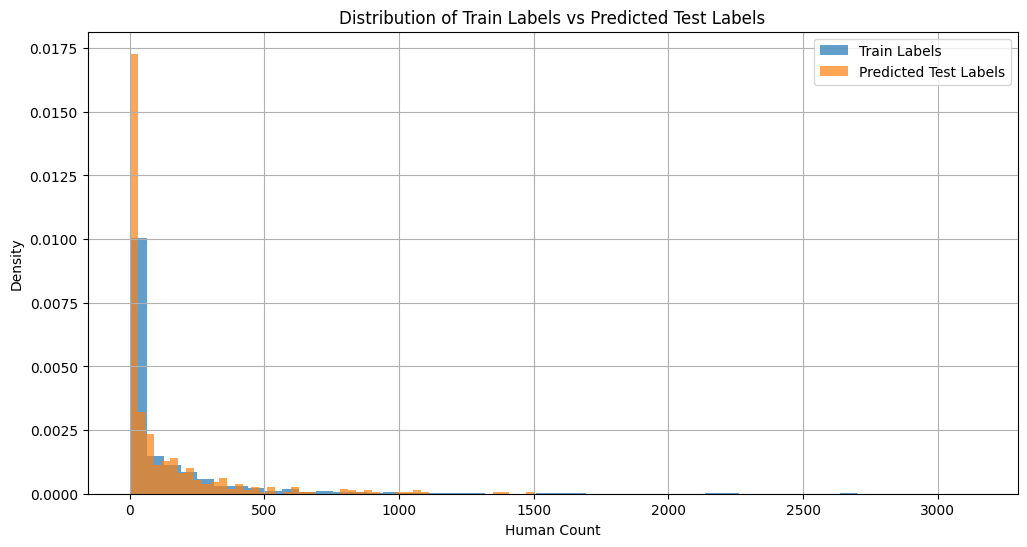

In [ ]:
# ==============================================================================
# SEL 11: VISUALISASI DISTRIBUSI LABEL
# ==============================================================================

# Pastikan DataFrame ada
if 'train_df' in locals() and 'submission_df' in locals():
    print("Plotting train label distribution vs predicted test label distribution...")

    plt.figure(figsize=(12, 6))

    # Plot distribusi label training
    plt.hist(train_df['human_num'], bins=50, alpha=0.7, label='Train Labels', density=True)

    # Plot distribusi label prediksi test
    plt.hist(submission_df['predicted_count'], bins=50, alpha=0.7, label='Predicted Test Labels', density=True)

    plt.title('Distribution of Train Labels vs Predicted Test Labels')
    plt.xlabel('Human Count')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Error: train_df or submission_df not found. Cannot plot distributions.")
    print("Please ensure previous cells (especially Sel 3 and Sel 10) were executed successfully.")